# **BINARY IMAGE CLASSIFICATION USING QUANTUM TRANSFER LEARNING.**

# **Classical-to-quantum transfer learning**

# In this notebook:

## Network A -> **Classical pre-trained model**
## Network B -> **Quantum model**

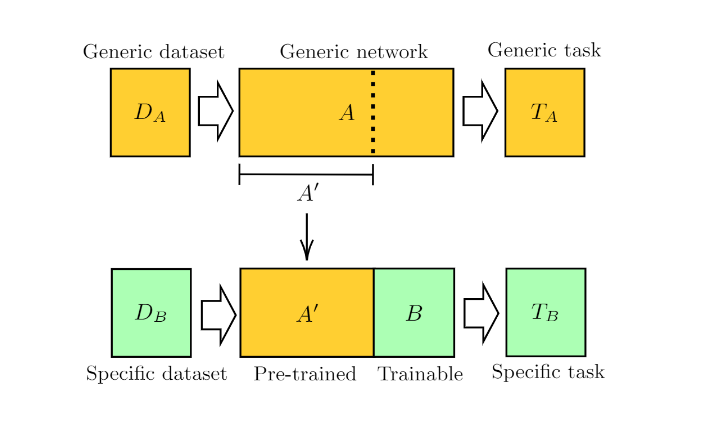

In [63]:
!pip install pennylane

In [65]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

In [95]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 20              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 5 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

Initializing PennyLane device with a default.qubit backend.

In [96]:
dev = qml.device("default.qubit", wires=n_qubits)

In [97]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Image preprocessing **as per the pre-trained model worked** **

# **Link to pre-trained res-net models: https://pytorch.org/vision/stable/models/resnet.html**

In [98]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/content/drive/MyDrive/hymenoptera_data/hymenoptera_data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Let us show a batch of the test data, just to have an idea of the classification problem.

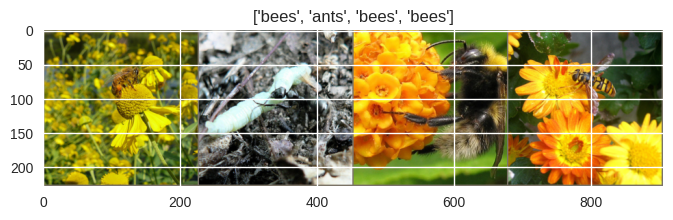

In [99]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

## Variational quantum circuit


## Defining **different layers individually which are used later** in Q-circuit


In [100]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

Defining quantum circuit through the PennyLane qnode decorator

In [101]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

## Dressed quantum circuit
This is a combination of:

1. A classical pre-processing layer (nn.Linear).

2. A classical activation function (torch.tanh).

3. A constant np.pi/2.0 scaling.

4. The previously defined quantum circuit (quantum_net).

5. A classical post-processing layer (nn.Linear).


**The input of the module is a batch of vectors with 512 real parameters (features) and the output is a batch of vectors with two real outputs (associated with the two classes of images: ants and bees).**

In [102]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):


        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):


        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

# Hybrid classical-quantum model

## **Loading classical pre-trained network ResNet18 from the torchvision.models**
## **Link to pre-trained res-net models: https://pytorch.org/vision/stable/models/resnet.html**

## **Freeze all the weights** since they should not be trained.

## **Replace the last fully connected layer with our trainable dressed quantum circuit (DressedQuantumNet)**.

In [103]:
resnet18_hybrid = torchvision.models.resnet18(pretrained=True)

for param in resnet18_hybrid.parameters():
    param.requires_grad = False


# resnet18_hybrid.fc is the last layer of ResNet18
resnet18_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
resnet18_hybrid = resnet18_hybrid.to(device)

## Loss function

In [104]:
criterion = nn.CrossEntropyLoss()

## Adam Optimizer

In [105]:
optimizer_hybrid = optim.Adam(resnet18_hybrid.fc.parameters(), lr=step)

### **Learning rate scheduler** using gamma_lr_scheduler every 5 epochs.

In [106]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=5, gamma=gamma_lr_scheduler
)

# **TRAINING FUNCTION**

In [107]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

## Using (Resnet-18 + Quantum) hybrid model

In [108]:
resnet18_hybrid = train_model(
    resnet18_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs
)

Training started:
Phase: train Epoch: 1/20 Loss: 0.6968 Acc: 0.5000        
Phase: validation   Epoch: 1/20 Loss: 0.6179 Acc: 0.6471        
Phase: train Epoch: 2/20 Loss: 0.6343 Acc: 0.6639        
Phase: validation   Epoch: 2/20 Loss: 0.5572 Acc: 0.8170        
Phase: train Epoch: 3/20 Loss: 0.5854 Acc: 0.7418        
Phase: validation   Epoch: 3/20 Loss: 0.5034 Acc: 0.8758        
Phase: train Epoch: 4/20 Loss: 0.5737 Acc: 0.7213        
Phase: validation   Epoch: 4/20 Loss: 0.4605 Acc: 0.9216        
Phase: train Epoch: 5/20 Loss: 0.5158 Acc: 0.8115        
Phase: validation   Epoch: 5/20 Loss: 0.4320 Acc: 0.9542        
Phase: train Epoch: 6/20 Loss: 0.5095 Acc: 0.8279        
Phase: validation   Epoch: 6/20 Loss: 0.4166 Acc: 0.9477        
Phase: train Epoch: 7/20 Loss: 0.4825 Acc: 0.8811        
Phase: validation   Epoch: 7/20 Loss: 0.4211 Acc: 0.9412        
Phase: train Epoch: 8/20 Loss: 0.5056 Acc: 0.8197        
Phase: validation   Epoch: 8/20 Loss: 0.4096 Acc: 0.9542       

# Visualizing the model predictions (resnet-18 + quantum)


In [109]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

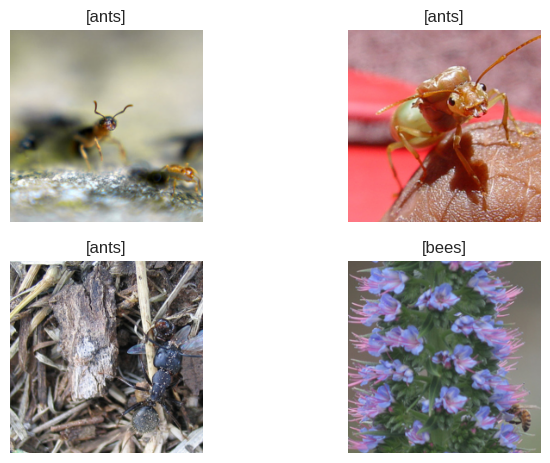

In [110]:
visualize_model(resnet18_hybrid, num_images=batch_size)
plt.show()

# Hybrid classical-quantum model

## **Loading classical pre-trained network ResNet34 from the torchvision.models**
## **Link to pre-trained res-net models: https://pytorch.org/vision/stable/models/resnet.html**

## **Freeze all the weights** since they should not be trained.

## **Replace the last fully connected layer with our trainable dressed quantum circuit (DressedQuantumNet)**.

In [111]:
resnet34_hybrid = torchvision.models.resnet34(pretrained=True)

for param in resnet34_hybrid.parameters():
    param.requires_grad = False


# Notice that resnet34_hybrid.fc is the last layer of ResNet18
resnet34_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
resnet34_hybrid = resnet34_hybrid.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Loss function

In [112]:
criterion = nn.CrossEntropyLoss()

## Adam Optimizer

In [113]:
optimizer_hybrid = optim.Adam(resnet34_hybrid.fc.parameters(), lr=step)

### **Learning rate scheduler** using gamma_lr_scheduler every 5 epochs.

In [114]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=5, gamma=gamma_lr_scheduler
)

In [115]:
resnet34_hybrid = train_model(
    resnet34_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs
)

Training started:
Phase: train Epoch: 1/20 Loss: 0.6559 Acc: 0.6311        
Phase: validation   Epoch: 1/20 Loss: 0.6475 Acc: 0.6667        
Phase: train Epoch: 2/20 Loss: 0.5591 Acc: 0.7418        
Phase: validation   Epoch: 2/20 Loss: 0.5352 Acc: 0.8170        
Phase: train Epoch: 3/20 Loss: 0.5266 Acc: 0.8033        
Phase: validation   Epoch: 3/20 Loss: 0.4557 Acc: 0.8954        
Phase: train Epoch: 4/20 Loss: 0.4896 Acc: 0.8033        
Phase: validation   Epoch: 4/20 Loss: 0.4302 Acc: 0.8627        
Phase: train Epoch: 5/20 Loss: 0.4205 Acc: 0.8852        
Phase: validation   Epoch: 5/20 Loss: 0.3947 Acc: 0.9020        
Phase: train Epoch: 6/20 Loss: 0.4182 Acc: 0.8811        
Phase: validation   Epoch: 6/20 Loss: 0.3994 Acc: 0.8824        
Phase: train Epoch: 7/20 Loss: 0.4470 Acc: 0.8402        
Phase: validation   Epoch: 7/20 Loss: 0.3724 Acc: 0.9216        
Phase: train Epoch: 8/20 Loss: 0.4184 Acc: 0.8689        
Phase: validation   Epoch: 8/20 Loss: 0.3704 Acc: 0.9281       

# Visualizing the model predictions(resnet-34 + quantum)
We first define a visualization function for a batch of test data.

In [116]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

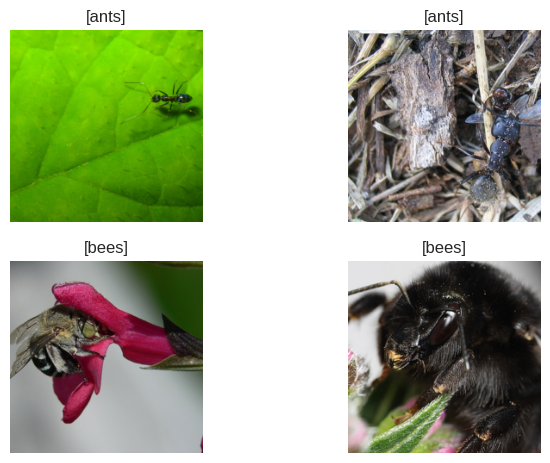

In [117]:
visualize_model(resnet34_hybrid, num_images=batch_size)
plt.show()